### Recreating Horizon Finding Method from "A Hierachical Horizon Detection Algorithm" by Yu-Fei Shen et al.

Eric Graves
Started June 5, 2019

### Notes:
- cv.Canny():
    - filters with GuassianBlur, kernal size = 5x5
    - has hysteresis buit-in (label pixels as strong or weak and remove weak)


(853, 1280)


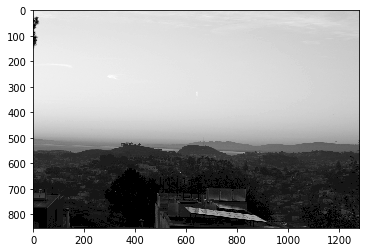

In [1]:
# Imports and environment setup
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
%matplotlib inline

img = cv.imread('image6.png',0)
h,w = img.shape[:2]
print(img.shape)
plt.imshow(img,cmap='gray')
plt.show()

In [2]:
img = cv.imread('image6.png',0)
# Blur with low pass filter: 
#-- Gaussian sigma = num_rows / 50
rows,cols = img.shape[:2]

ksize = 7 # must be an odd value
img_bl = cv.bilateralFilter(img,ksize,175,75) # bilateral method is slow but the best at keeping edges

# plt.figure(figsize = (12,36))
# plt.subplot(611),plt.imshow(img,cmap='gray')
# plt.subplot(612),plt.imshow(img_bl,cmap='gray')

# Canny edge detector
#-- Keep egdes with stregth > 5/num_cols


(<matplotlib.axes._subplots.AxesSubplot at 0x23026ad7668>,
 <matplotlib.image.AxesImage at 0x2302a210438>)

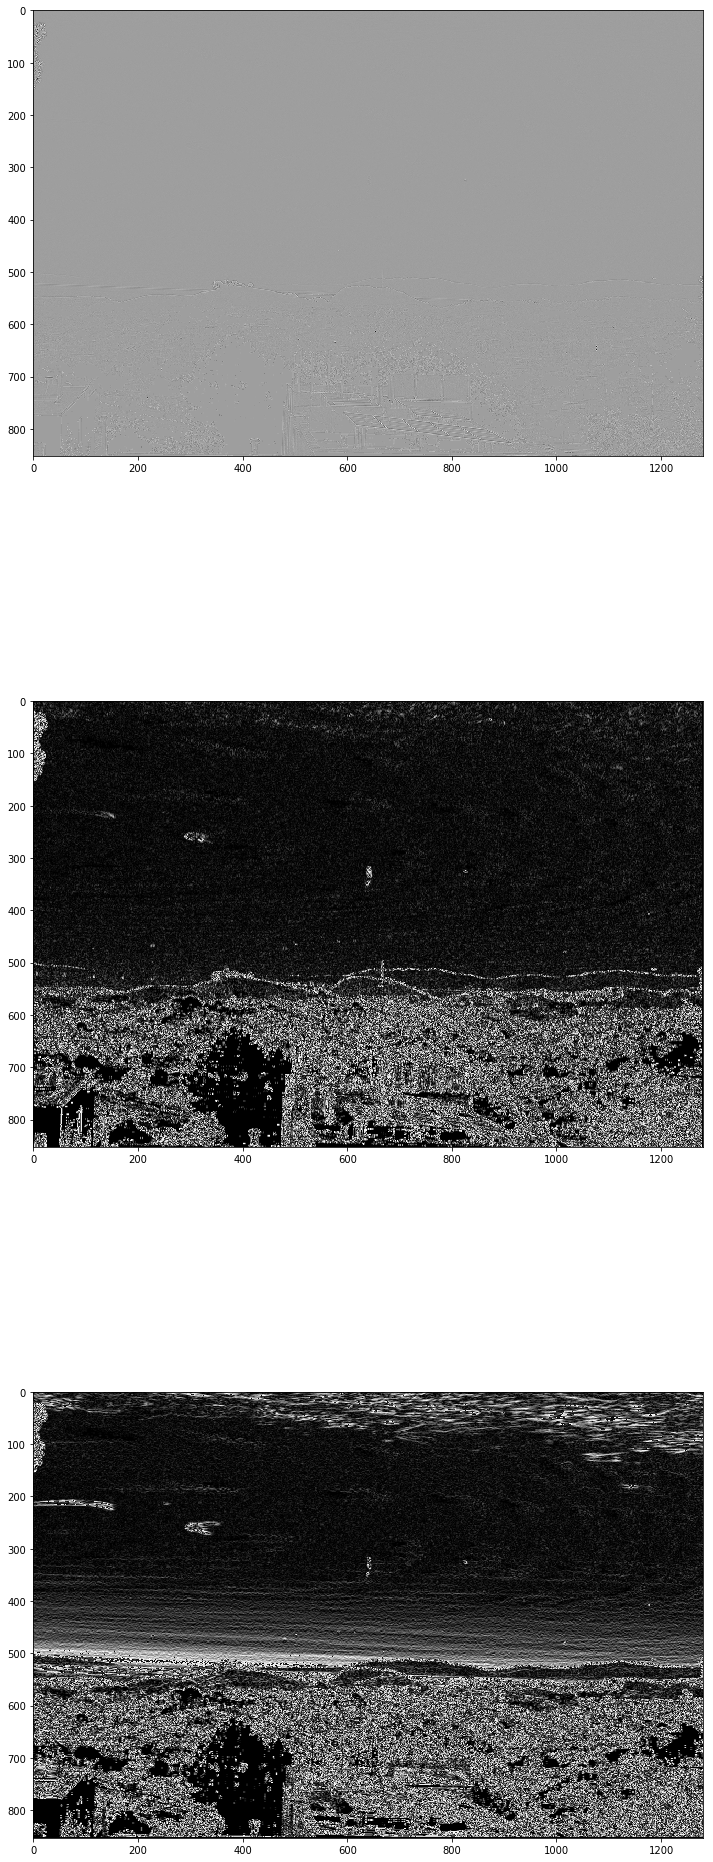

In [3]:
# Other edge detction methods
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)

# convert to b/w for display
abs_sobelx = np.absolute(sobelx)
sobelx_8u = np.uint8(abs_sobelx)
abs_sobely = np.absolute(sobely)
sobely_8u = np.uint8(abs_sobely)


plt.figure(figsize = (12,36))
plt.subplot(311),plt.imshow(laplacian,cmap='gray') 
plt.subplot(312),plt.imshow(sobelx_8u,cmap='gray') 
plt.subplot(313),plt.imshow(sobely_8u,cmap='gray') 

(<matplotlib.axes._subplots.AxesSubplot at 0x2302c7d1f28>,
 <matplotlib.image.AxesImage at 0x2302f7abcf8>)

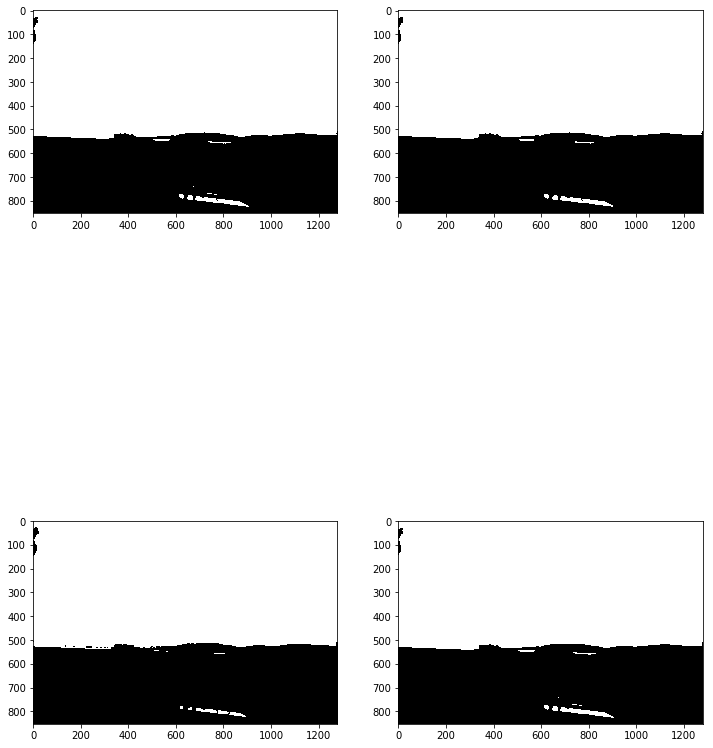

In [14]:
# use Otsu's method to calculate thresholds
high_thresh, img_thresh = cv.threshold(img_bl, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
low_thresh = 0.5*high_thresh

# morphological transforms to remove noise (hopefully)
# -- Need to decide what kernal shape is best for horizon finding
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(img_thresh,cv.MORPH_OPEN,kernel, iterations = 2) # erosion followed by dialation
closing = cv.morphologyEx(img_thresh,cv.MORPH_CLOSE,kernel, iterations = 2) # dialation followed by erosion
erosion = cv.erode(img_thresh,kernel,iterations = 2)

plt.figure(figsize = (12,36))
plt.subplot(421),plt.imshow(img_thresh,cmap='gray') 
plt.subplot(422),plt.imshow(opening,cmap='gray') 
plt.subplot(423),plt.imshow(erosion,cmap='gray') 
plt.subplot(424),plt.imshow(closing,cmap='gray') 

In [ ]:
# median threshold
v = np.median(img)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edge1 = cv.Canny(img, lower, upper)

edge2 = cv.Canny(img, low_thresh, high_thresh) # Otsu Thresholding

plt.figure(figsize = (12,36))
plt.subplot(211),plt.imshow(edge1,cmap='gray') 
plt.subplot(212),plt.imshow(edge2,cmap='gray')

In [ ]:
# Hough Transform 
img_lines = img

lines = cv.HoughLines(edge1, 1, np.pi / 180, 50, None, 0, 0)
    
if lines is not None:
    print("Found " + str(len(lines)) + " lines")
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(img_lines, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
else:
    print("No lines found")
    
plt.figure(figsize = (12,36))
plt.subplot(111),plt.imshow(img)